In [17]:
#Importing needed modules.
import matplotlib.pyplot as plt
from os import listdir , mkdir
from random import sample
from shutil import rmtree , copyfile
from tensorflow.keras.preprocessing.image import load_img , ImageDataGenerator
from tensorflow.keras import layers , Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import RMSprop
#Instancing from 'ImageDataGenerator' object with data augmentation setting.
train_gen = ImageDataGenerator(rescale=1/255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               horizontal_flip=True,
                               zoom_range=0.2)
gen = ImageDataGenerator(rescale=1/255)

In [2]:
#Creating a function for making basic paths.
def Make_paths(base_path,classes)->str:
    '''function docstring'''
    if 'ready_to_generate' in listdir(base_path) :
        rmtree(f'{base_path}\\ready_to_generate')
    mkdir(f'{base_path}\\ready_to_generate')
    mkdir(f'{base_path}\\ready_to_generate\\train')
    mkdir(f'{base_path}\\ready_to_generate\\validation')
    for name in classes :
        mkdir(f'{base_path}\\ready_to_generate\\train\\{name}')
        mkdir(f'{base_path}\\ready_to_generate\\validation\\{name}')
    return f'{base_path}\\ready_to_generate\\train' , f'{base_path}\\ready_to_generate\\validation'

In [35]:
base = "D:\\datasets\\Brain_tumor_4classes\\Data"
labels = [l for l in listdir(base) if l != 'ready_to_generate']
#Storing train and valid paths in two variables.
train,valid = Make_paths(base,labels)

In [36]:
#Creating a function to split pictures.
def Split(base_path,train_path,valid_path,train_size)->None :
    '''function docstring'''
    if train_size > 0 :
        for folder in listdir(base_path) :
            if folder == 'ready_to_generate' :
                continue
            s = (train_size*len(listdir(f'{base_path}\\{folder}')))//100
            selecting = sample(listdir(f'{base_path}\\{folder}'),s)
            for pic in listdir(f'{base_path}\\{folder}') :
                if pic not in selecting :
                    copyfile(f'{base_path}\\{folder}\\{pic}',f'{valid_path}\\{folder}\\{pic}')
                else :
                    copyfile(f'{base_path}\\{folder}\\{pic}',f'{train_path}\\{folder}\\{pic}')
    else :
        print('Invalid train size given.')

In [37]:
train_size = int(input('Enter train size :'))
Split(base,train,valid,train_size)

Enter train size :80


In [39]:
#Generating photos.
ready_train = gen.flow_from_directory(train,target_size=(150,150),batch_size=24)
ready_valid = gen.flow_from_directory(valid,target_size=(150,150),batch_size=12)

Found 2475 images belonging to 4 classes.
Found 621 images belonging to 4 classes.


In [40]:
#Defining a model by defining a function.
def Teacher(active,optm,Loss,Metric,pre_trained_model)->None:
    '''function docstring'''
    pre = pre_trained_model(include_top=False,input_shape=(150,150,3))
    for layer in pre.layers :
        layer.trainable = False
    last_layer = pre.get_layer('mixed7')
    last_out = last_layer.output
    x = layers.Flatten()(last_out)
    x = layers.Dense(64,activation='relu')(x)
    x = layers.Dense(4,activation=active)(x)
    model = Model(pre.input,x)
    model.compile(optimizer=optm,
                 loss=Loss,
                 metrics=[Metric])
    return model

In [41]:
#Data train.
history = Teacher('softmax',
                  RMSprop(learning_rate=0.001),
                  'categorical_crossentropy',
                  'accuracy',
                  InceptionV3).fit(ready_train,
                                   epochs=10,
                                   validation_data=ready_valid)

Epoch 1/10
104/104 [==============================] - 29s 257ms/step - loss: 0.8959 - accuracy: 0.6982 - val_loss: 0.5904 - val_accuracy: 0.7778
Epoch 2/10
104/104 [==============================] - 23s 219ms/step - loss: 0.3069 - accuracy: 0.8978 - val_loss: 0.3620 - val_accuracy: 0.8631
Epoch 3/10
104/104 [==============================] - 24s 229ms/step - loss: 0.1722 - accuracy: 0.9422 - val_loss: 0.3159 - val_accuracy: 0.8808
Epoch 4/10
104/104 [==============================] - 24s 233ms/step - loss: 0.1063 - accuracy: 0.9636 - val_loss: 0.2616 - val_accuracy: 0.9130
Epoch 5/10
104/104 [==============================] - 24s 230ms/step - loss: 0.0665 - accuracy: 0.9770 - val_loss: 0.3672 - val_accuracy: 0.8824
Epoch 6/10
104/104 [==============================] - 25s 238ms/step - loss: 0.0459 - accuracy: 0.9859 - val_loss: 0.2715 - val_accuracy: 0.9179
Epoch 7/10
104/104 [==============================] - 24s 233ms/step - loss: 0.0247 - accuracy: 0.9935 - val_loss: 0.3540 - val_ac

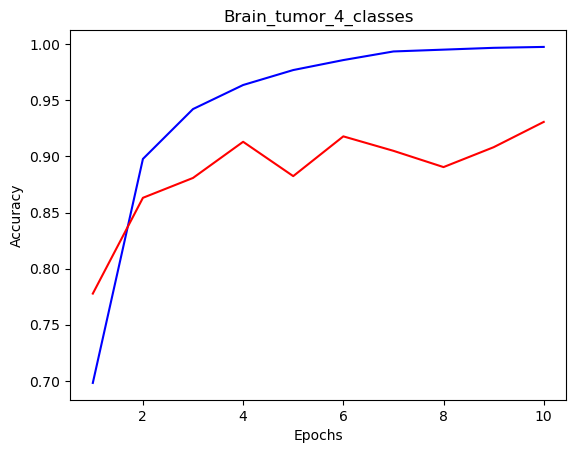

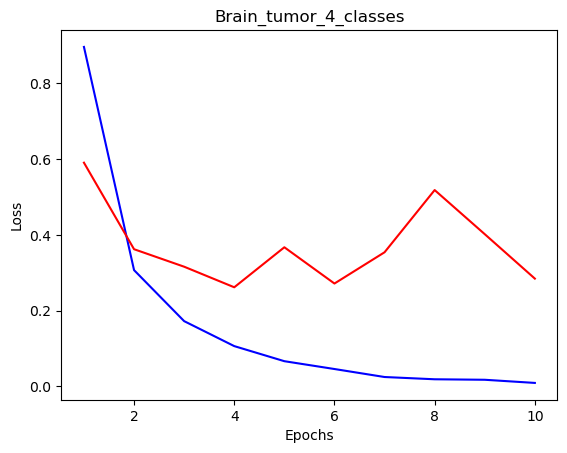

In [42]:
#Visualize models performance
epoch = range(1,len(history.epoch)+1)
results = history.history
plt.plot(epoch,results['accuracy'],'blue')
plt.plot(epoch,results['val_accuracy'],'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Brain_tumor_4_classes')
plt.show()
plt.plot(epoch,results['loss'],'blue')
plt.plot(epoch,results['val_loss'],'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Brain_tumor_4_classes')
plt.show()